# Montando nosso modelo de previsão

In [137]:
#Importando as bibliotecas necessárias para a execução da atividade
import pandas as pd
import numpy as np
import random
from scipy.stats import poisson
import seaborn as sns
%matplotlib inline

In [62]:
#Importando os arquivos necessários que contém os dados sobre as seleções e sobre os jogos da Copa
selecoes = pd.read_excel('/content/DadosCopaDoMundoQatar2022.xlsx', sheet_name ='selecoes', index_col = 0) #Com "index_col = 0", nós setamos os nomes das seleções, que estão na coluna "0" como o index de nosso DF
jogos = pd.read_excel('/content/DadosCopaDoMundoQatar2022.xlsx', sheet_name ='jogos')

In [63]:
#Dando uma olhada nos DF's
jogos.head()

,data,hora,grupo,seleção1,seleção2,estádio
0,2022-11-21,07:00:00,A,Senegal,Holanda,AL THUMAMA
1,2022-11-21,13:00:00,A,Catar,Equador,AL KHOR
2,2022-11-25,10:00:00,A,Catar,Senegal,AL THUMAMA
3,2022-11-25,13:00:00,A,Holanda,Equador,INTER. KHALIFA
4,2022-11-29,12:00:00,A,Holanda,Catar,AL KHOR


In [64]:
selecoes.head()

,Grupo,GrupoNumero,NomeEmIngles,PosiçãoRankingFIFA,ValorDeMercado,PontosELO,PontosRankingFIFA,Confederação,Copas,JogadorDestaque,FotoJogadorDestaque,LinkBandeiraPequena,LinkBandeiraGrande
Seleção,,,,,,,,,,,,,
Alemanha,E,E2,Germany,11,746.50,1963,1659,UEFA,4,Thomas Müller,https://github.com/ricardorocha86/PrevisaoEspo...,https://cloudinary.fifa.com/api/v3/picture/fla...,https://flagdownload.com/wp-content/uploads/Fl...
Arábia Saudita,C,C2,Saudi Arabia,53,23.10,1692,1436,AFC,0,Salem Al-Dawsari,https://github.com/ricardorocha86/PrevisaoEspo...,https://cloudinary.fifa.com/api/v3/picture/fla...,https://flagdownload.com/wp-content/uploads/Fl...
Argentina,C,C1,Argentina,3,608.00,2086,1771,CONMEBOL,2,Lionel Messi,https://github.com/ricardorocha86/PrevisaoEspo...,https://cloudinary.fifa.com/api/v3/picture/fla...,https://flagdownload.com/wp-content/uploads/Fl...
Austrália,D,D4,Australia,39,40.33,1719,1484,AFC,0,Ajdin Hrustic,https://github.com/ricardorocha86/PrevisaoEspo...,https://cloudinary.fifa.com/api/v3/picture/fla...,https://flagdownload.com/wp-content/uploads/Fl...
Bélgica,F,F1,Belgium,2,559.00,2007,1822,UEFA,0,Kevin De Bruyne,https://github.com/ricardorocha86/PrevisaoEspo...,https://cloudinary.fifa.com/api/v3/picture/fla...,https://flagdownload.com/wp-content/uploads/Fl...


In [67]:
#Separando a coluna com os dados FIFA de pontuação das Seleções
elo = selecoes['PontosELO']
elo

Seleção
Alemanha          1963
Arábia Saudita    1692
Argentina         2086
Austrália         1719
Bélgica           2007
Brasil            2169
Camarões          1610
Canadá            1776
Catar             1642
Coreia do Sul     1786
Costa Rica        1743
Croácia           1927
Dinamarca         1952
Equador           1871
Espanha           2048
Estados Unidos    1797
França            2005
Gana              1567
Holanda           2050
Inglaterra        1957
Irã               1760
Japão             1787
Marrocos          1766
México            1809
País de Gales     1791
Polônia           1814
Portugal          2006
Senegal           1677
Sérvia            1898
Suíça             1902
Tunísia           1726
Uruguai           1936
Name: PontosELO, dtype: int64

In [68]:
#Normalizando os dados de pontos da ELO para que fiquem no intervalo de 0,15 a 1,00
a, b = min(elo), max(elo) 
eloa, elob = 0.15, 1 
b1 = (elob - eloa)/(b-a) 
b0 = elob - b*b1
forca = b0 + b1*elo 

forca.sort_values(ascending = False) #Com o parametro "ascending = False", nós ordenamos a coluna pela normalização dos pontos ELO

Seleção
Brasil            1.000000
Argentina         0.882807
Holanda           0.831977
Espanha           0.829153
Bélgica           0.771262
Portugal          0.769850
França            0.768439
Alemanha          0.709136
Inglaterra        0.700664
Dinamarca         0.693605
Uruguai           0.671013
Croácia           0.658306
Suíça             0.623007
Sérvia            0.617359
Equador           0.579236
Polônia           0.498754
México            0.491694
Estados Unidos    0.474751
País de Gales     0.466279
Japão             0.460631
Coreia do Sul     0.459219
Canadá            0.445100
Marrocos          0.430980
Irã               0.422508
Costa Rica        0.398505
Tunísia           0.374502
Austrália         0.364618
Arábia Saudita    0.326495
Senegal           0.305316
Catar             0.255897
Camarões          0.210714
Gana              0.150000
Name: PontosELO, dtype: float64

In [168]:
def Resultado(gols1, gols2):
    if gols1 > gols2:
        res = 'Vitória'
    if gols1 < gols2:
        res = 'Derrota' 
    if gols1 == gols2:
        res = 'Empate'       
    return res

def MediasPoisson(selecao1, selecao2): #Utilizaremos a distribuição de Poisson por ela ser academicamente aceita para dados de futebol
    forca1 = forca[selecao1]
    forca2 = forca[selecao2] 
    mgols = 2.75
    l1 = mgols*forca1/(forca1 + forca2)
    l2 = mgols*forca2/(forca1 + forca2)
    return [l1, l2]
    
def Distribuicao(media):
    probs = []
    for i in range(7):
        probs.append(poisson.pmf(i,media))
    probs.append(1-sum(probs))
    return pd.Series(probs, index = ['0', '1', '2', '3', '4', '5', '6', '7+'])


def Pontos(gols1, gols2):
    rst = Resultado(gols1, gols2)
    if rst == 'Vitória':
        pontos1, pontos2 = 3, 0
    if rst == 'Empate':
        pontos1, pontos2 = 1, 1
    if rst == 'Derrota':
        pontos1, pontos2 = 0, 3
    return pontos1, pontos2, rst


def Jogo(selecao1, selecao2):
    l1, l2 = MediasPoisson(selecao1, selecao2)
    gols1 = int(np.random.poisson(lam = l1, size = 1))
    gols2 = int(np.random.poisson(lam = l2, size = 1))
    saldo1 = gols1 - gols2
    saldo2 = -saldo1
    pontos1, pontos2, result = Pontos(gols1, gols2)
    placar = f'{gols1}x{gols2}'
    return [f"gols {selecao1}: {gols1}",f"gols {selecao2}: {gols2}", f"saldo {selecao1}: {saldo1}", f"saldo {selecao2}: {saldo2}", f"pontos {selecao1}: {pontos1}", f"pontos2: {pontos2}", f"{selecao1} : {result}", placar]


def ProbabilidadesPartida(selecao1, selecao2):
    l1, l2 = MediasPoisson(selecao1, selecao2)
    d1, d2 = Distribuicao(l1), Distribuicao(l2)  
    matriz = np.outer(d1, d2)    #   Monta a matriz de probabilidades

    vitoria = np.tril(matriz).sum()-np.trace(matriz)    #Soma a triangulo inferior menos a diagonal
    derrota = np.triu(matriz).sum()-np.trace(matriz)    #Soma a triangulo superior menos a diagonal
    empate = 1 - (vitoria + derrota) #O empate é 1 subtraido das chances acumuladas de empate e derrota da seleção 1
    probs = np.around([vitoria, empate , derrota], 3)
    probsp = [f'{100*i:.1f}%' for i in probs]

    nomes = ['0', '1', '2', '3', '4', '5', '6', '7+']
    matriz = pd.DataFrame(matriz, columns = nomes, index = nomes)
    matriz.index = pd.MultiIndex.from_product([[selecao1], matriz.index])
    matriz.columns = pd.MultiIndex.from_product([[selecao2], matriz.columns])
    heatmap = sns.heatmap(matriz, cmap="crest_r", annot=True, fmt=".3f")
    heatmap.set(xlabel=None, ylabel=None)

    output = {'seleção1': selecao1, 'seleção2': selecao2, 
             'f1': forca[selecao1], 'f2': forca[selecao2], 
             'media1': l1, 'media2': l2, 
             'probabilidades': probsp, 'matriz': matriz, 'mapa de calor': heatmap}
    return output

In [119]:
#Simulando um jogo
Jogo('Brasil', 'Sérvia')

['gols Brasil: 2',
 'gols Sérvia: 2',
 'saldo Brasil: 0',
 'saldo Sérvia: 0',
 'pontos Brasil: 1',
 'pontos2: 1',
 'Brasil : Empate',
 '2x2']

{'seleção1': 'Brasil',
 'seleção2': 'Sérvia',
 'f1': 1.0,
 'f2': 0.6173588039867113,
 'media1': 1.700302983618343,
 'media2': 1.049697016381657,
 'probabilidades': ['52.6%', '24.0%', '23.4%'],
 'matriz':              Sérvia                                                    \
                   0         1         2         3         4         5   
 Brasil 0   0.063928  0.067105  0.035220  0.012323  0.003234  0.000679   
        1   0.108697  0.114099  0.059884  0.020954  0.005499  0.001154   
        2   0.092409  0.097001  0.050911  0.017814  0.004675  0.000981   
        3   0.052374  0.054977  0.028855  0.010096  0.002649  0.000556   
        4   0.022263  0.023369  0.012265  0.004292  0.001126  0.000236   
        5   0.007571  0.007947  0.004171  0.001459  0.000383  0.000080   
        6   0.002145  0.002252  0.001182  0.000414  0.000109  0.000023   
        7+  0.000657  0.000690  0.000362  0.000127  0.000033  0.000007   
 
                                    
                  

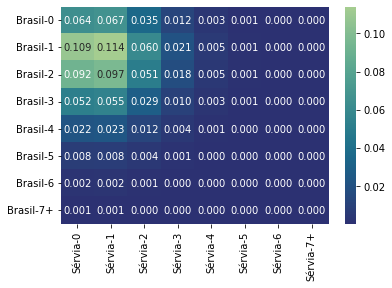

In [167]:
ProbabilidadesPartida('Brasil', 'Sérvia')

# Prever os Jogos da Copa!

In [14]:
jogos['Vitória'] = None
jogos['Empate'] = None
jogos['Derrota'] = None

for i in range(jogos.shape[0]):
    selecao1 = jogos['seleção1'][i]
    selecao2 = jogos['seleção2'][i]
    v, e, d = ProbabilidadesPartida(selecao1, selecao2)['probabilidades']
    jogos.at[i,'Vitória'] = v
    jogos.at[i,'Empate'] = e
    jogos.at[i,'Derrota'] = d

jogos.to_excel('outputEstimativasJogosCopa.xlsx')
jogos

,data,hora,grupo,seleção1,seleção2,estádio,Vitória,Empate,Derrota
0,2022-11-21,07:00:00,A,Senegal,Holanda,AL THUMAMA,28.3%,24.9%,46.8%
1,2022-11-21,13:00:00,A,Catar,Equador,AL KHOR,32.3%,25.4%,42.3%
2,2022-11-25,10:00:00,A,Catar,Senegal,AL THUMAMA,17.2%,22.1%,60.6%
3,2022-11-25,13:00:00,A,Holanda,Equador,INTER. KHALIFA,64.4%,21.0%,14.6%
4,2022-11-29,12:00:00,A,Holanda,Catar,AL KHOR,68.4%,19.6%,12.0%
5,2022-11-29,12:00:00,A,Equador,Senegal,INTER. KHALIFA,20.7%,23.3%,56.0%
6,2022-11-21,10:00:00,B,Inglaterra,Irã,INTER. KHALIFA,54.6%,23.6%,21.8%
7,2022-11-21,16:00:00,B,Estados Unidos,País de Gales,AL RAYYAN,43.0%,25.3%,31.7%
8,2022-11-25,07:00:00,B,País de Gales,Irã,AL RAYYAN,40.1%,25.5%,34.4%
9,2022-11-25,16:00:00,B,Inglaterra,Estados Unidos,AL KHOR,46.1%,25.0%,28.9%


In [15]:
jogos.to_excel('outputEstimativasJogosCopa.xlsx')